# **Projet NLP: Classification IA and Human Texts**

<ins>Group :</ins>
- Thomas Sinapi
- Pierre Derathe
- Manitas Bahri

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import gensim
import textdistance

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from pprint import pprint
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec

In [3]:
# nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kiba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_csv("data.csv")
X_total, y_total = df["text"], df["generated"].astype("int")

In [15]:
n = 2000

id_ai = (y_total == 1).values.nonzero()[0]
id_human = (y_total == 0).values.nonzero()[0][:len(id_ai)]

X_human = X_total.iloc[id_human][:n]
X_ai = X_total.iloc[id_ai][:n]

y_human = y_total.iloc[id_human][:n]
y_ai = y_total.iloc[id_ai][:n]

X = pd.concat([X_human, X_ai])
y = pd.concat([y_human, y_ai])

In [21]:
# Putting the sample data in a csv file for easy access
training = pd.DataFrame({'text': X, 'generated': y})

# Specify the file path where you want to save the CSV file
csv_file_path = 'training.csv'

# Save the DataFrame to a CSV file
training.to_csv(csv_file_path)

print(f"DataFrame saved to {csv_file_path}")

DataFrame saved to training.csv


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **1. <ins>Data Analysing</ins>**

In [22]:
print("Human Text")
pprint(X[y == 0].iloc[11])

Human Text
('"When I had a car I was always tense. I\'m much happier this way." Heidrun '
 'Walter source 1. For many years, people have depended on cars to take them '
 'places and allow them to live a normal life. However, the recent decline in '
 'driving and car sales has proven that there are many advantages to limiting '
 'car usage. Limiting car usage would help reduce the greenhouse effect, would '
 'help reduce smog and other lowair pollution, as well as helping promote '
 'aspects of the eeconomy which differ from purely car sales and '
 'transportation.\n'
 '\n'
 'To begin with, the greenhouse effect, a large part of which is caused by '
 'cars and their emissions, is endangering not only our environments and '
 'ecosystems, but also life as we know it. According to source 1 In german '
 'Suburb, Life Goes On Without Cars, passengers car are the cause of 12% of '
 'greenhouse gas emissions in Europe and also responsible for approximately '
 '50% of emissions in certain parts

In [23]:
print("AI Text")
pprint(X[y == 1].iloc[0])

AI Text
('This essay will analyze, discuss and prove one reason in favor of keeping '
 'the Electoral College in the United States for its presidential elections. '
 'One of the reasons to keep the electoral college is that it is better for '
 'smaller, more rural states to have more influence as opposed to larger '
 'metropolitan areas that have large populations. The electors from these '
 'states are granted two votes each. Those from larger, more populated areas '
 'are granted just one vote each. Smaller states tend to hold significant '
 'power because their two votes for president and vice president add up more '
 'than the votes of larger states that have many electors. This is because of '
 'the split of the electoral votes. Some argue that electors are not bound to '
 'vote for the candidate who won the most votes nationally. They do not have '
 "to vote for their own state's nominee unless their state has a winner take "
 'all system. However, there are states that have adop

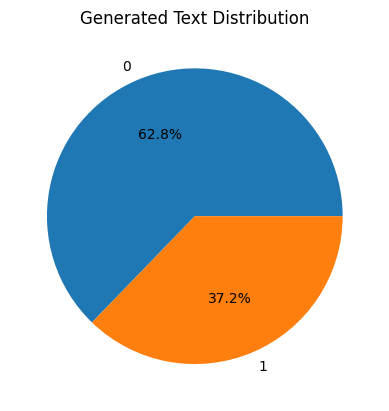

In [25]:
# Plot the distribution of the generated text
plt.pie(y_total.value_counts(), labels=y_total.value_counts().index, autopct='%1.1f%%')
plt.title("Generated Text Distribution")
plt.show()

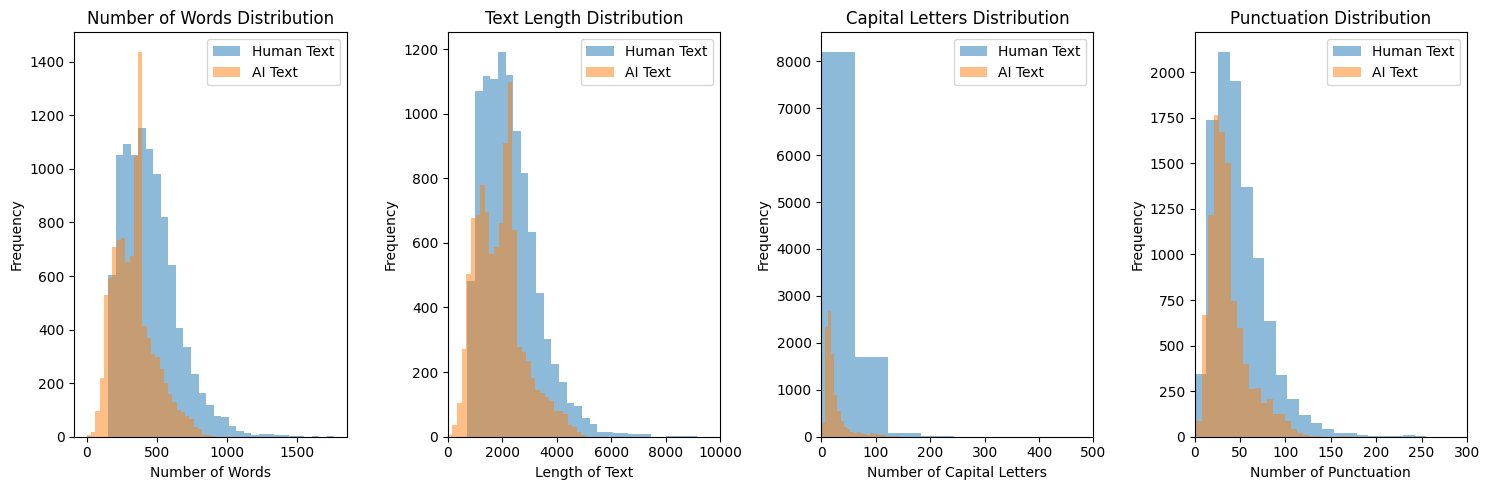

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

# Plot the distribution of the number of words by class
ax[0].hist(X[y == 0].apply(word_tokenize).str.len(), bins=30, alpha=0.5, label="Human Text")
ax[0].hist(X[y == 1].apply(word_tokenize).str.len(), bins=30, alpha=0.5, label="AI Text")
ax[0].set_title("Number of Words Distribution")
ax[0].set_xlabel("Number of Words")
ax[0].set_ylabel("Frequency")
ax[0].legend()
# ax[0].set_xlim(0, 1000)

# Plot the distribution of the text length by class
ax[1].hist(X[y == 0].str.len(), bins=30, alpha=0.5, label="Human Text")
ax[1].hist(X[y == 1].str.len(), bins=30, alpha=0.5, label="AI Text")
ax[1].set_title("Text Length Distribution")
ax[1].set_xlabel("Length of Text")
ax[1].set_ylabel("Frequency")
ax[1].legend()
ax[1].set_xlim(0, 10000)

# Plot the distribution of the capital letters by class
count_upper_g = X.str.findall(r"[A-Z]").str.len().groupby(y)
ax[2].hist(count_upper_g.get_group(0), bins=30, alpha=0.5, label="Human Text")
ax[2].hist(count_upper_g.get_group(1), bins=30, alpha=0.5, label="AI Text")
ax[2].set_title("Capital Letters Distribution")
ax[2].set_xlabel("Number of Capital Letters")
ax[2].set_ylabel("Frequency")
ax[2].legend()
ax[2].set_xlim(0, 500)

# Plot the distribution of the punctuation by class
count_punct_g = X.str.findall(r"[^\w\s]").str.len().groupby(y)
ax[3].hist(count_punct_g.get_group(0), bins=30, alpha=0.5, label="Human Text")
ax[3].hist(count_punct_g.get_group(1), bins=30, alpha=0.5, label="AI Text")
ax[3].set_title("Punctuation Distribution")
ax[3].set_xlabel("Number of Punctuation")
ax[3].set_ylabel("Frequency")
ax[3].legend()
ax[3].set_xlim(0, 300)

plt.tight_layout()
plt.show()

## 2. **<ins>Preprocessing</ins>**

In [17]:
def remove_stopwords(tokens_list):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = np.empty_like(tokens_list)
    
    for i, tokens in enumerate(tokens_list):
        filtered_tokens[i] = [word for word in tokens if word.lower() not in stop_words]
    
    return pd.Series(filtered_tokens)

In [18]:
tokenizer = RegexpTokenizer(r'\w+')
X_train = X_train.apply(lambda x: tokenizer.tokenize(x.lower()))
X_test = X_test.apply(lambda x: tokenizer.tokenize(x.lower()))

In [19]:
X_train = remove_stopwords(X_train)
X_test = remove_stopwords(X_test)

### 2.1. <ins>TF-IDF</ins>

In [20]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train.apply(" ".join))
X_test_tfidf = tfidf.transform(X_test.apply(" ".join))

### 2.1. <ins>Word2Vec</ins>

In [21]:
word2vec = Word2Vec(X_train, window=5, min_count=10, workers=-1, vector_size=100)

In [22]:
def get_vector(text, model):
    vector = [0] * model.vector_size
    count = 0
    
    for word in text:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    
    if count != 0:
        vector = [x / count for x in vector]
    
    return vector

In [23]:
X_train_w2v = X_train.apply(lambda x: get_vector(x, word2vec)).values.tolist()
X_test_w2v = X_test.apply(lambda x: get_vector(x, word2vec)).values.tolist()

## 3. **<ins>Model Comparative *Multinomial NB* vs *Random Forest*<ins>**

Etudes comparatives de modèles de classification de textes avec TF-IDF et Word2Vec.

### 3.1 <ins>Multinomial Naive Bayes (TF-IDF)<ins>

In [24]:
mb = MultinomialNB()
y_cv = cross_val_predict(mb, X_train_tfidf, y_train, cv=5)

mb.fit(X_train_tfidf, y_train)
y_pred = mb.predict(X_test_tfidf)

print(f"(TF-IDF) Cross Validation Accuracy: {accuracy_score(y_train, y_cv):.3f}")

(TF-IDF) Cross Validation Accuracy: 0.954


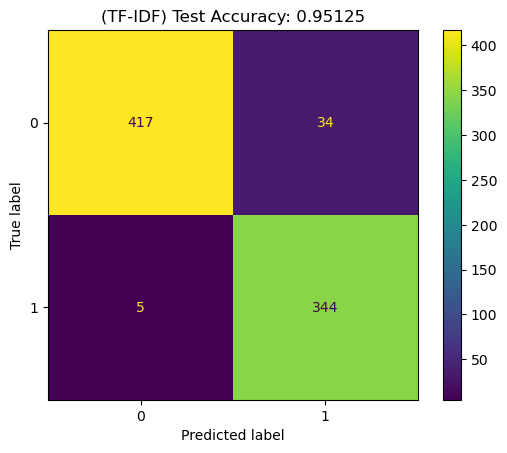

In [25]:
ConfusionMatrixDisplay.from_predictions(y_pred, y_test)
plt.title(f"(TF-IDF) Test Accuracy: {accuracy_score(y_test, y_pred)}")
plt.show()

### 3.2 <ins>Multinomial Naive Bayes (Word2Vec)</ins>

In [26]:
mms = MinMaxScaler()
X_train_w2v_ss = mms.fit_transform(X_train_w2v)
X_test_w2v_ss = mms.transform(X_test_w2v)

In [27]:
mb = MultinomialNB()
y_cv = cross_val_predict(mb, X_train_w2v_ss, y_train, cv=5)

mb.fit(X_train_w2v_ss, y_train)
y_pred = mb.predict(X_test_w2v_ss)

print(f"(Word2Vec) Cross Validation Accuracy: {accuracy_score(y_train, y_cv):.3f}")

(Word2Vec) Cross Validation Accuracy: 0.803


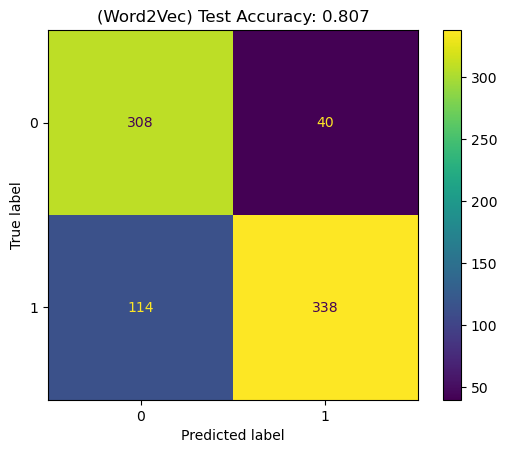

In [28]:
ConfusionMatrixDisplay.from_predictions(y_pred, y_test)
plt.title(f"(Word2Vec) Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
plt.show()

### 3.3 <ins> Random Forest (TF-IDF)</ins>

In [29]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
y_cv = cross_val_predict(rf, X_train_tfidf, y_train, cv=5)

rf.fit(X_train_tfidf, y_train)
y_pred = rf.predict(X_test_tfidf)

print(f"(TF-IDF) Cross Validation Accuracy: {accuracy_score(y_train, y_cv):.3f}")

(TF-IDF) Cross Validation Accuracy: 0.985


### 3.4 <ins> Random Forest (Word2Vec)</ins>

In [30]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
y_cv = cross_val_predict(rf, X_train_w2v, y_train, cv=5)

rf.fit(X_train_w2v, y_train)
y_pred = rf.predict(X_test_w2v)

print(f"(Word2Vec) Cross Validation Accuracy: {accuracy_score(y_train, y_cv):.3f}")

(Word2Vec) Cross Validation Accuracy: 0.963


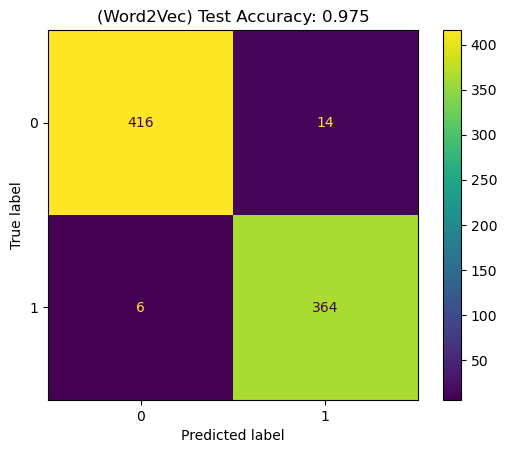

In [31]:
ConfusionMatrixDisplay.from_predictions(y_pred, y_test)
plt.title(f"(Word2Vec) Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
plt.show()

### 3.4 bis <ins> Comparaison min_count avec Word2Vec</ins>

In [32]:
for min_count in range(1, 10):
    word2vec = Word2Vec(X_train, window=5, min_count=min_count, workers=-1, vector_size=100)
    X_train_w2v = X_train.apply(lambda x: get_vector(x, word2vec)).values.tolist()
    X_test_w2v = X_test.apply(lambda x: get_vector(x, word2vec)).values.tolist()
    
    rf = RandomForestClassifier(random_state=0, n_jobs=-1)
    y_cv = cross_val_predict(rf, X_train_w2v, y_train, cv=5)
    
    rf.fit(X_train_w2v, y_train)
    y_pred = rf.predict(X_test_w2v)
    
    print(f"Min Count: {min_count} - Cross Validation Accuracy: {accuracy_score(y_train, y_cv):.3f} - Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")

Min Count: 1 - Cross Validation Accuracy: 0.956 - Test Accuracy: 0.958
Min Count: 2 - Cross Validation Accuracy: 0.955 - Test Accuracy: 0.964
Min Count: 3 - Cross Validation Accuracy: 0.955 - Test Accuracy: 0.971
Min Count: 4 - Cross Validation Accuracy: 0.954 - Test Accuracy: 0.974
Min Count: 5 - Cross Validation Accuracy: 0.960 - Test Accuracy: 0.954
Min Count: 6 - Cross Validation Accuracy: 0.957 - Test Accuracy: 0.966
Min Count: 7 - Cross Validation Accuracy: 0.953 - Test Accuracy: 0.965
Min Count: 8 - Cross Validation Accuracy: 0.962 - Test Accuracy: 0.959
Min Count: 9 - Cross Validation Accuracy: 0.961 - Test Accuracy: 0.968
